# Checkpoint 1

Implement here your algorithm to interpolate/extrapolate the activation time field from timings recorded in the 20 electrodes of the mapping catheter.

The algorithm should output the following information:
- a reconstruction of the activation times evaluated at each point of a structured grid on the square (-1.5, 1.5)x(-1.5, 1.5),
- an approximation of the conduction velocity (a clinical biomarker) evaluated at each point of a structured grid on the same square.


In [74]:
# imports

import numpy as np
import matplotlib.pyplot as plt

In [33]:
!git clone https://github.com/Alepescinaa/ScientificTools
%cd ScientificTools/Project1/Cp1

Cloning into 'ScientificTools'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 147 (delta 38), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (147/147), 4.44 MiB | 11.28 MiB/s, done.
Resolving deltas: 100% (38/38), done.
/content/ScientificTools/Project1/Cp1/ScientificTools/Project1/Cp1


In [34]:
# loading of the dataset

CP1data = np.load("CP1data.npz")
CP1data = CP1data['arr_0']
len(CP1data)

100

# Display one recording

In [95]:
ind_disp = 49
x_meas = CP1data[ind_disp][0]
y_meas = CP1data[ind_disp][1]
t_meas = CP1data[ind_disp][2]

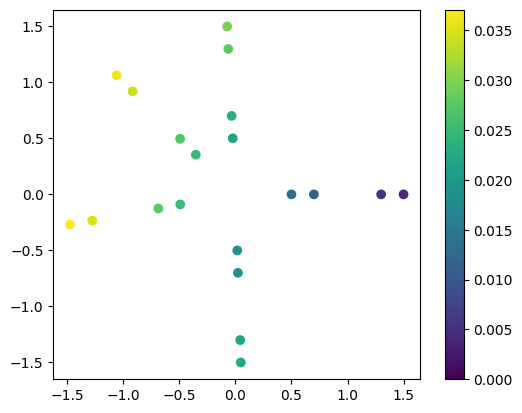

In [96]:
# Display a sample

plt.figure(1)
plt.scatter( x_meas,  y_meas, c=t_meas, vmin= 0, vmax=np.max(t_meas) )
plt.gca().set_aspect(1)
plt.colorbar()

In [77]:
from scipy.interpolate import griddata

X, Y = np.meshgrid(np.linspace(-1.5,1.5,1501), np.linspace(-1.5,1.5,1501))


# signature of the function

def checkpoint1_solution( x, y , t, X , Y ):

return time_pred,vel_pred



In [ ]:
from scipy.interpolate import griddata

X, Y = np.meshgrid(np.linspace(-1.5,1.5,1501), np.linspace(-1.5,1.5,1501))

def checkpoint1_solution( x, y , t, X , Y ):

    time_pred = griddata(list(zip(x, y)), t, (X, Y), method='nearest')

    grad_AT = np.gradient(time_pred)

    vel_pred = 1.0/( np.sqrt((grad_AT[0]/(3.0/1500))**2+(grad_AT[1]/(3.0/1500))**2) + 1e-4)

    return time_pred,vel_pred

time_pred,vel_pred = checkpoint1_solution( x_meas, y_meas , t_meas, X , Y )

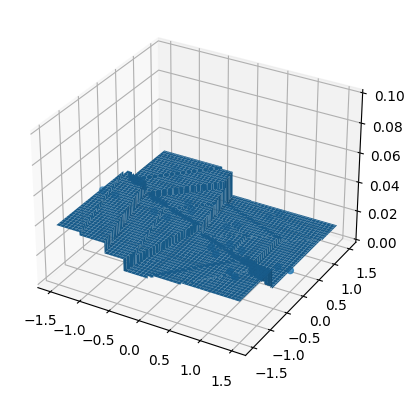

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X,Y,time_pred)
ax.axes.set_zlim3d(bottom=0, top=0.1)
ax.scatter3D(x_meas, y_meas, t_meas)

## **SPLINES**
A smoothing spline model for regression is a flexible non-parametric regression technique used for modeling the relationship between a response variable(time) and one or more predictor variables (position). It involves fitting a smooth curve to the observed data while penalizing roughness to avoid overfitting. λ is the smoothing parameter, a larger λ results in a smoother curve with less emphasis on fitting the data exactly. Since we have a small number of  observation (100) wer can exploit leave-one-out cross-validation (LOOCV) to choose an appropriate smoothing parameter.   

I choose splines of order 3 that means

*   polynomilas of order 2 at each interval
*   continuity at knots
-continuity of derivatives

-> so we can directly derive to get velocity conduction

**comments on the code**

We use bisplrep and bisplev to interpolate a 3D surface, kx and ky are the degree of the splines in the x and y axis respectively.

In [97]:
from scipy.interpolate import bisplrep, bisplev

def checkpoint1_solution(x, y, t, X, Y, s_value):
    # Create a B-spline representation of the data
    tck = bisplrep(x, y, t, s=s_value, kx=2, ky=2)

    # Evaluate the B-spline on the grid
    points_pred = bisplev(X[0, :], Y[:, 0], tck)

    # Extract the activation time predictions
    time_pred = points_pred

    # Compute the gradient of activation time using the B-spline derivatives
    grad_x = bisplev(X[0, :], Y[:, 0], tck, dx=1, dy=0)
    grad_y = bisplev(X[0, :], Y[:, 0], tck, dx=0, dy=1)

    vel_pred = 1.0/( np.sqrt((grad_x/(3.0/1500))**2+(grad_y/(3.0/1500))**2) + 1e-4)
    return time_pred, vel_pred

In [98]:
time_pred,vel_pred = checkpoint1_solution(x_meas, y_meas, t_meas, X, Y, 0.2)

## **RADIAL BASIS FUNCTIONS**

Notes:
* neighbors=value of the interpolant at each evaluation point will be computed using only this many nearest data points. (default whole domain)
* epsilon= sets the shape parameter of the radial basis functions. A smaller epsilon results in a more localized influence of each data point, similar to a smaller bandwidth in kernel density estimation.
* smoothing= penalization parameter
* degree= degree of the added polynomial (default for this kernel is 1 -> we should have differentiability)

In [113]:
from scipy.interpolate import RBFInterpolator

def checkpoint1_solution(x, y, t, X, Y, s_value):
    coordinates = np.column_stack((x, y))

    mesh_coordinates=np.column_stack((X.ravel(), Y.ravel()))

    rbf = RBFInterpolator(coordinates, t, neighbors=None, smoothing=s_value, kernel='thin_plate_spline', epsilon=None, degree=None)

    time_pred = rbf(mesh_coordinates)
    time_pred=time_pred.reshape(1501,1501)

    grad_x, grad_y = np.gradient(time_pred.reshape(X.shape))

    vel_pred = 1.0/( np.sqrt((grad_x/(3.0/1500))**2+(grad_y/(3.0/1500))**2) + 1e-4)
    vel_pred=vel_pred.reshape(1501,1501)
    return time_pred, vel_pred



In [105]:
time_pred,vel_pred = checkpoint1_solution(x_meas, y_meas, t_meas, X, Y, 0.2)

##** Parameters tuning**

In [ ]:
best_s_values = []  # List to store best s values for each observation
s_values=[0.1,0.2,0.3,0.4]

for index in range(100):
    x_obs = CP1data[index][0]
    y_obs = CP1data[index][1]
    t_obs = CP1data[index][2]

    best_s = None #is gonna keep track of each observation best parameter
    best_metric = float('inf')

    for s_value in s_values:
        total_mse = 0.0

        for i in range(20):
            x_train = np.delete(x_obs, i)
            y_train = np.delete(y_obs, i)
            t_train = np.delete(t_obs, i)

            x_val = x_obs[i]
            y_val = y_obs[i]
            t_val = t_obs[i]

            time_pred_val, _ = checkpoint1_solution(x_train, y_train, t_train, X, Y, s_value)

            i, j = np.where((X == x_val) & (Y == y_val))


            mse = ((time_pred_val[i, j] - t_val)**2)
            total_mse += mse

        avg_mse = total_mse / 20  # Average over all LOOCV folds

        # Update best_s if the current s_value is better
        if avg_mse < best_metric:
            best_metric = avg_mse
            best_s = s_value

    best_s_values.append(best_s)

In [ ]:
final_best_s = np.mean(best_s_values)
final_best_s

0.26899999999999996

## **Evaluation**


Activation map of time

(0.0, 0.04314386741275146)

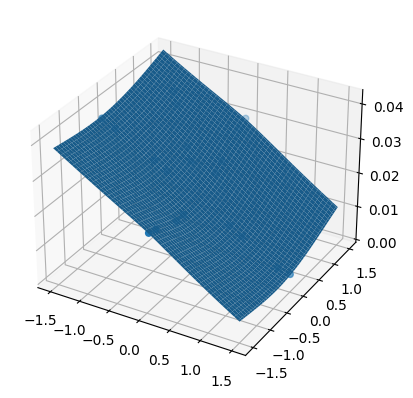

In [106]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X,Y,time_pred)
ax.scatter3D(x_meas, y_meas, t_meas)
ax.axes.set_zlim3d(bottom=0, top=np.max(time_pred))

Activation map of velocity

(0.0, 130.07607714539742)

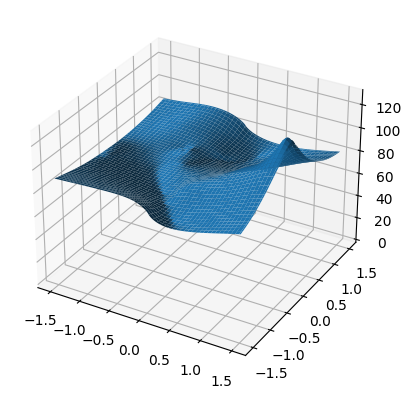

In [107]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X,Y,vel_pred)
ax.axes.set_zlim3d(bottom=0, top=np.max(vel_pred))

Display of activation maps overlapped to a specific observation

In [108]:
time_pred

array([[0.03857394, 0.03855233, 0.03853073, ..., 0.00539458, 0.00537303,
        0.00535148],
       [0.03857064, 0.03854902, 0.03852741, ..., 0.00539027, 0.00536873,
        0.00534718],
       [0.03856733, 0.03854571, 0.03852409, ..., 0.00538596, 0.00536442,
        0.00534289],
       ...,
       [0.04312511, 0.04310424, 0.04308337, ..., 0.01066514, 0.01064302,
        0.01062091],
       [0.04313449, 0.04311362, 0.04309276, ..., 0.0106753 , 0.01065318,
        0.01063107],
       [0.04314387, 0.04312301, 0.04310215, ..., 0.01068547, 0.01066334,
        0.01064122]])

In [109]:
num_rows = time_pred.shape[0] #need to swap the rows of the matrix of times if we want to use imshow matching the values of the time with the right (X,Y)
for i in range(num_rows // 2):
    time_pred[i], time_pred[num_rows - 1 - i] = time_pred[num_rows - 1 - i], time_pred[i].copy()

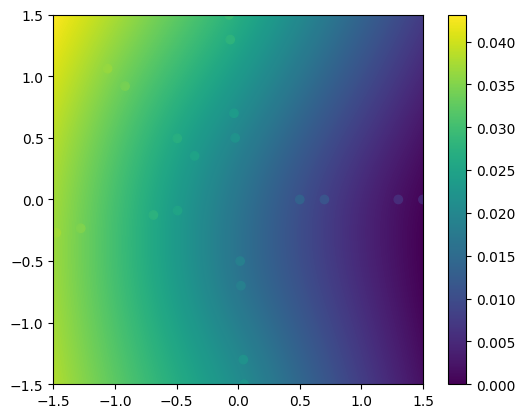

In [110]:
# Display a sample

plt.figure(1)
plt.imshow(time_pred, extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)])
plt.scatter( x_meas,  y_meas, c=t_meas, vmin= 0, vmax=np.max(time_pred))
plt.gca().set_aspect(1)
plt.colorbar()

Display of activation maps overlapped to all observation

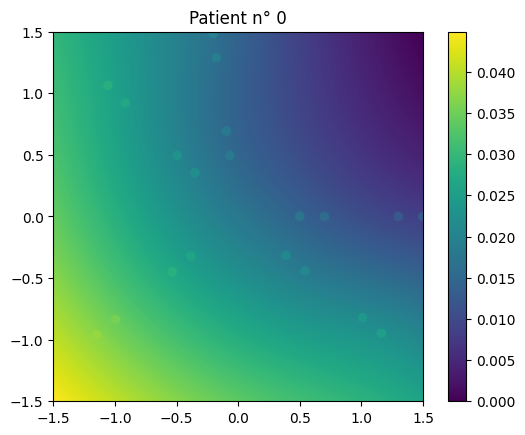

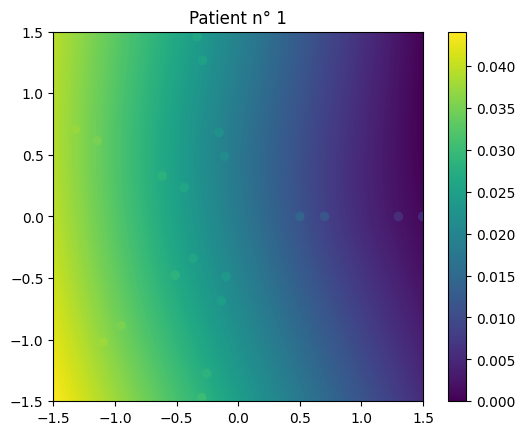

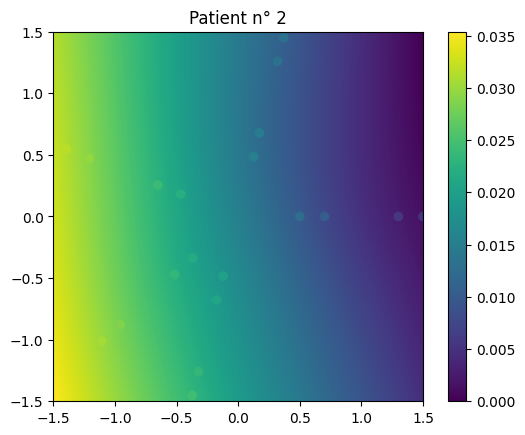

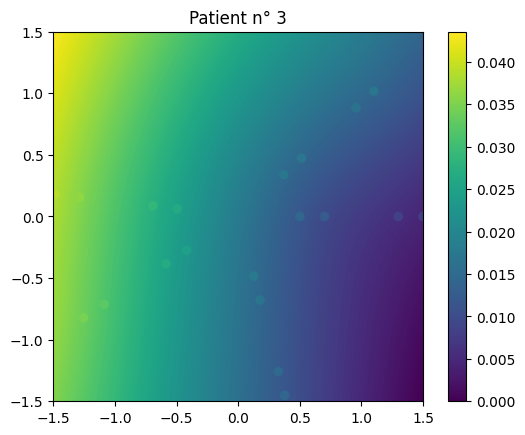

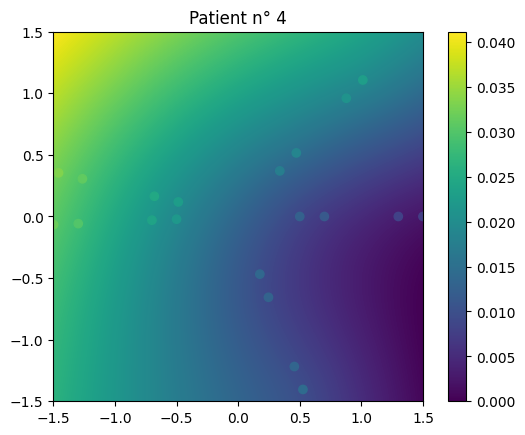

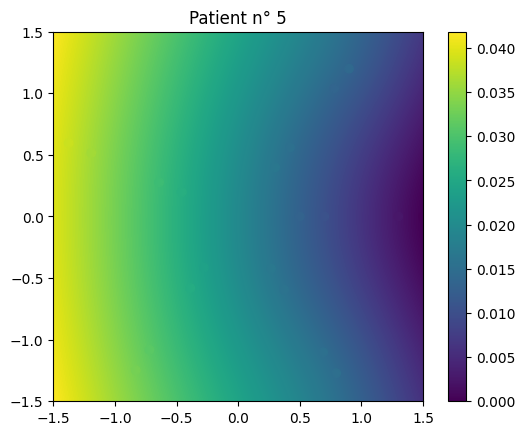

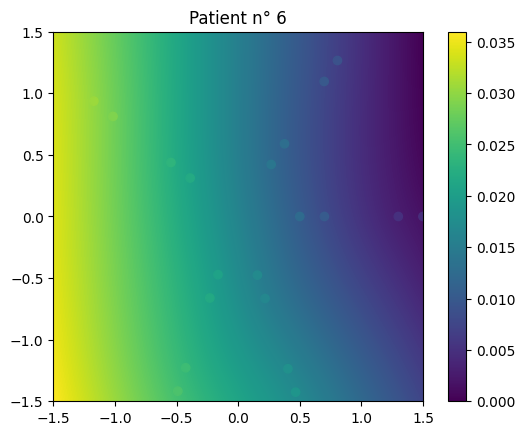

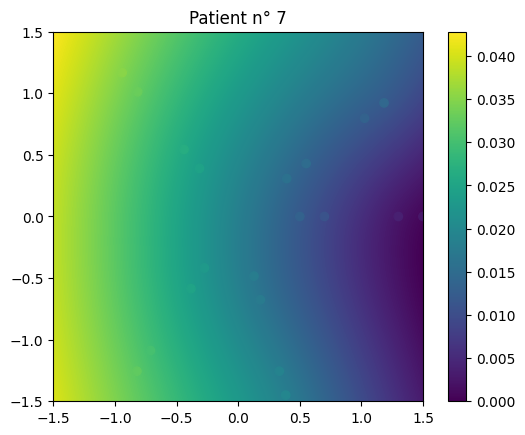

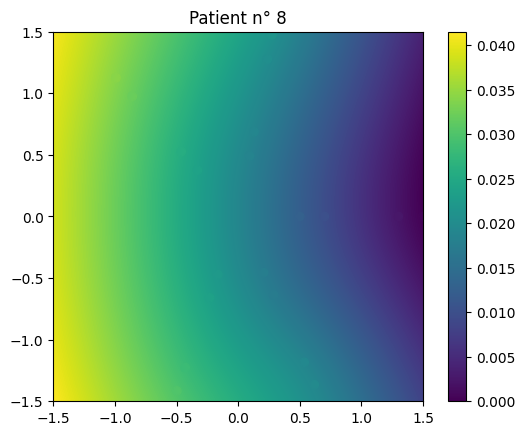

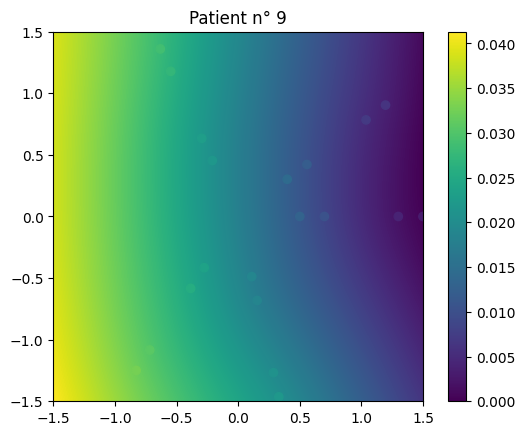

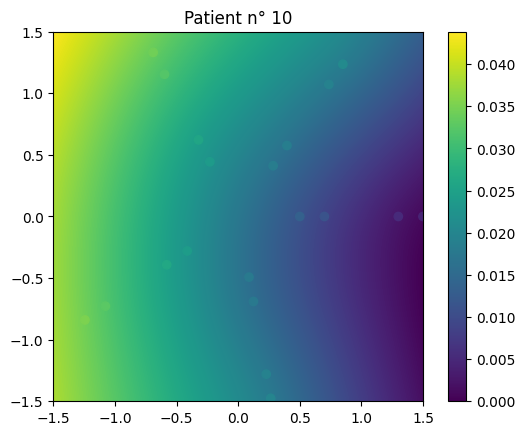

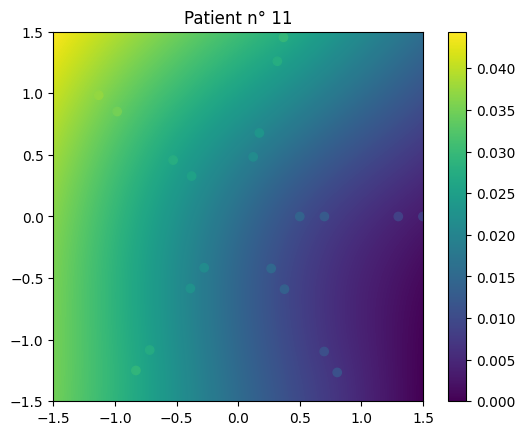

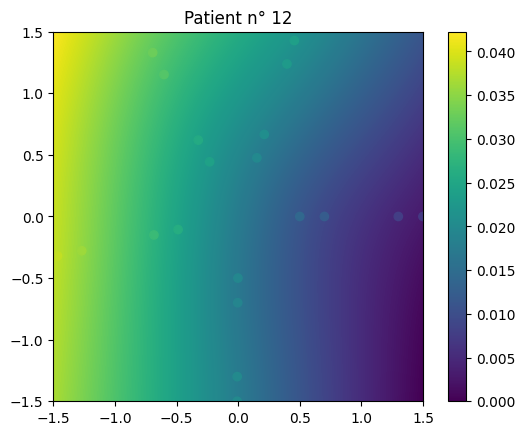

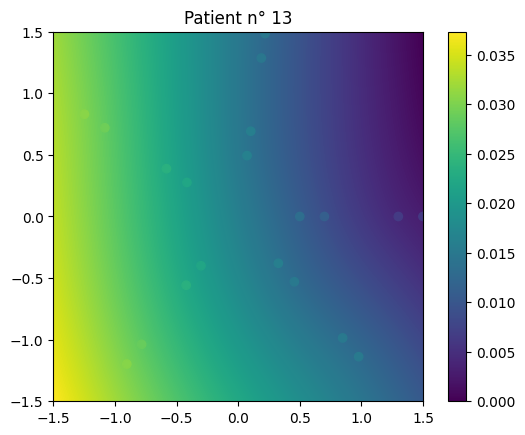

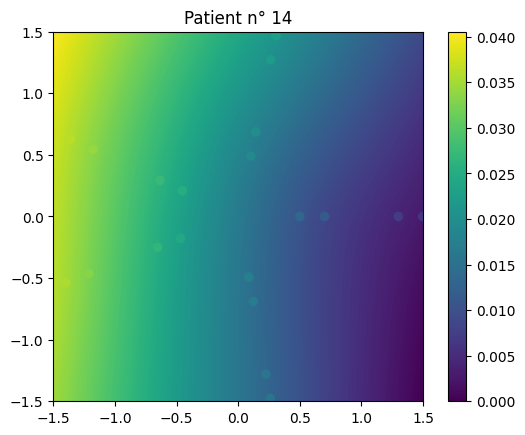

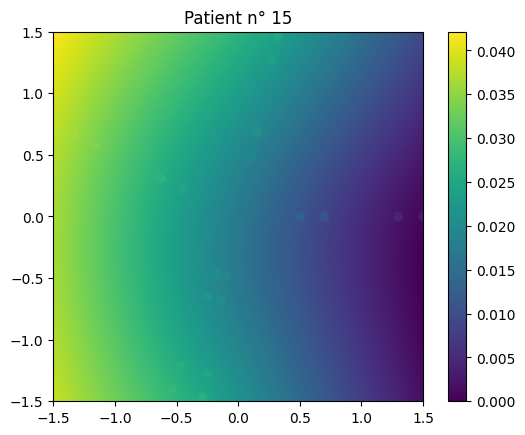

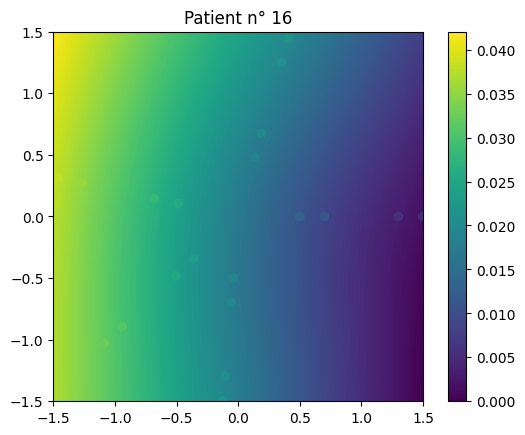

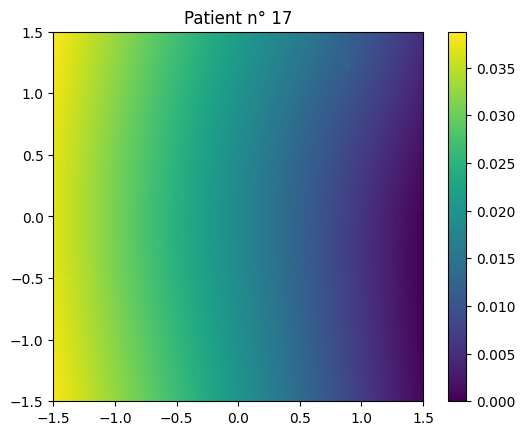

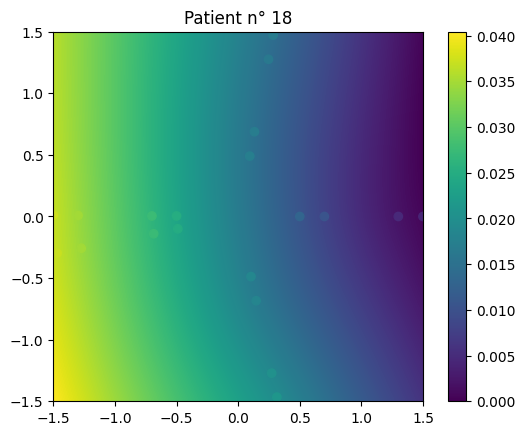

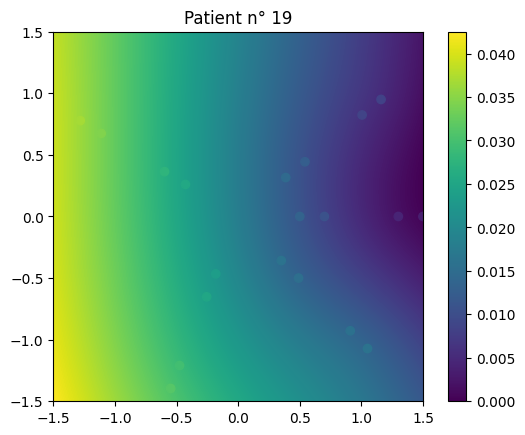

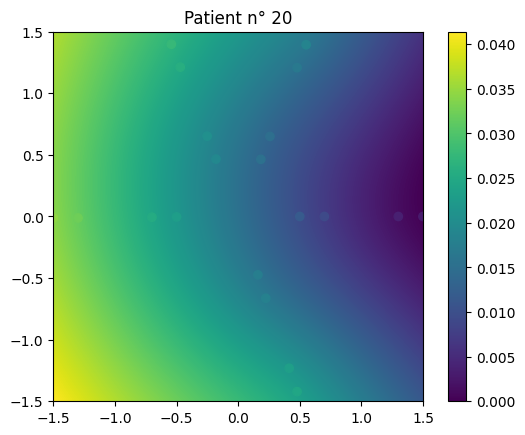

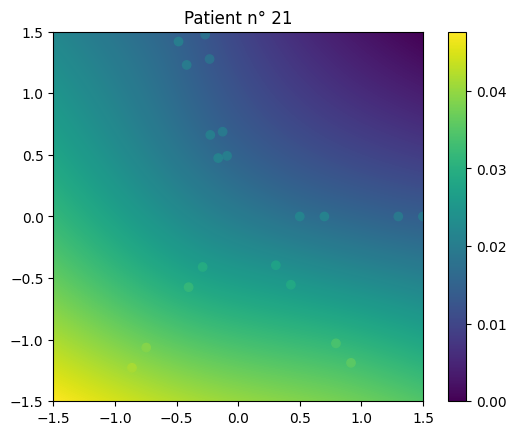

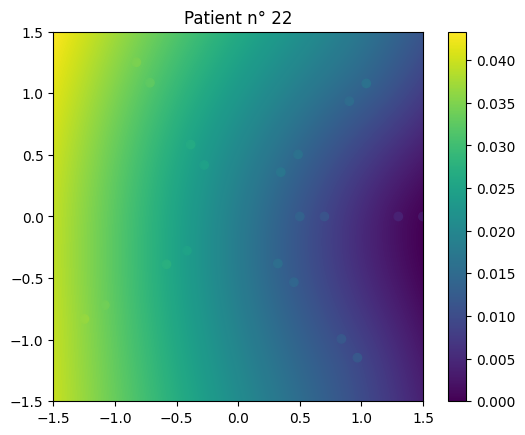

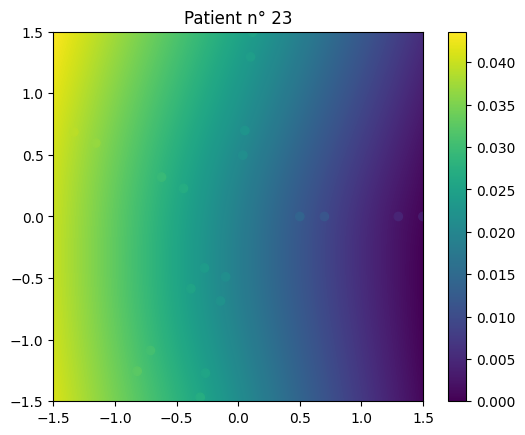

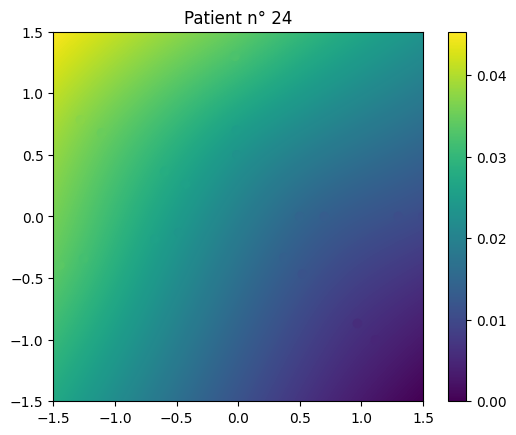

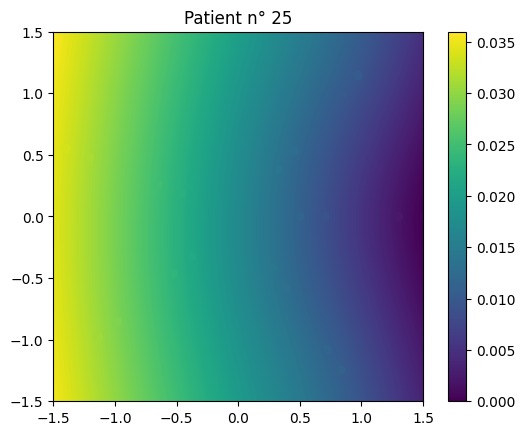

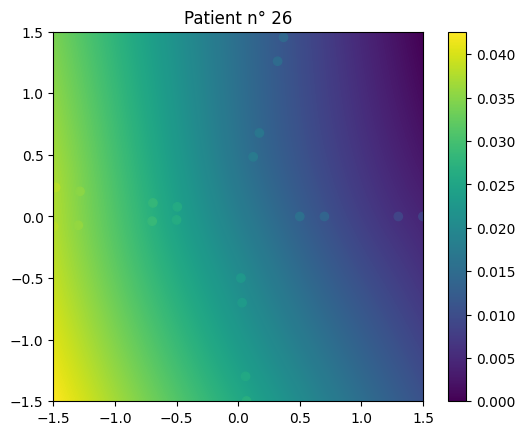

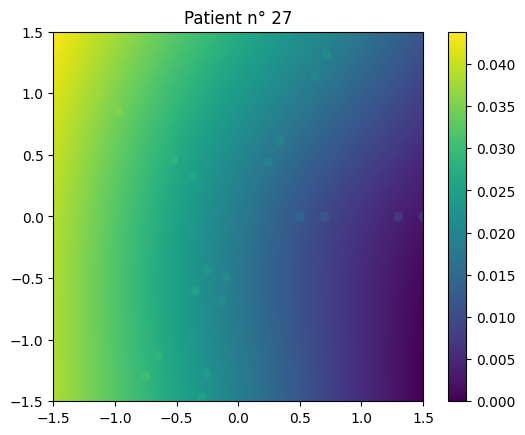

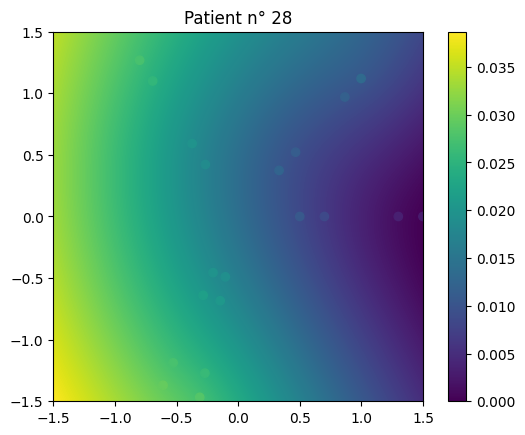

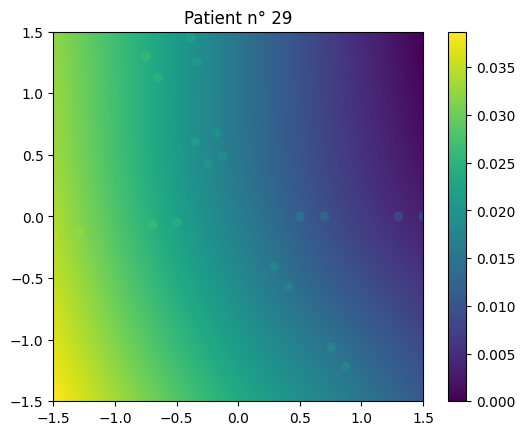

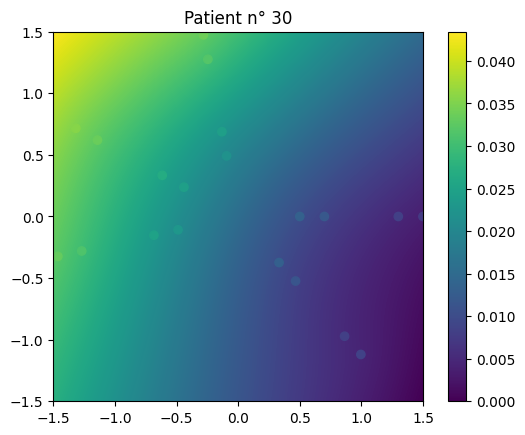

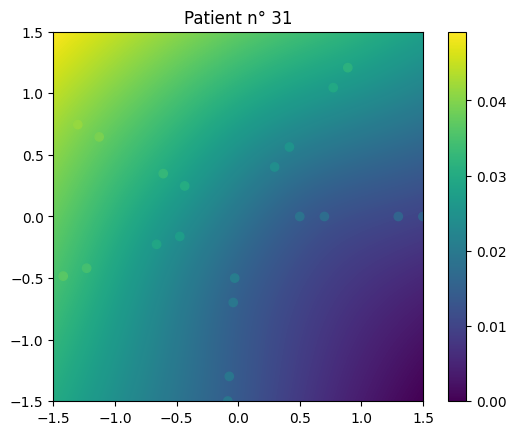

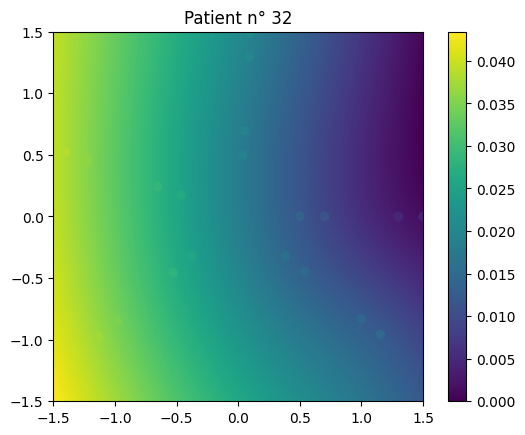

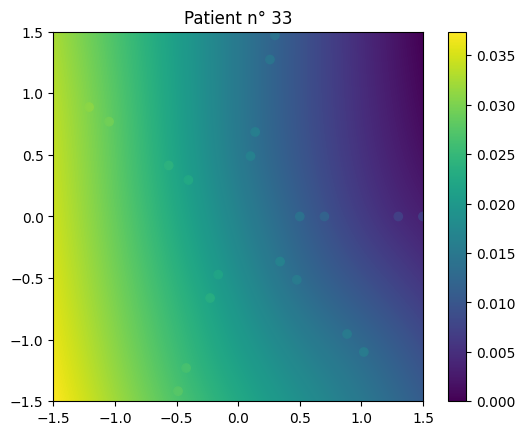

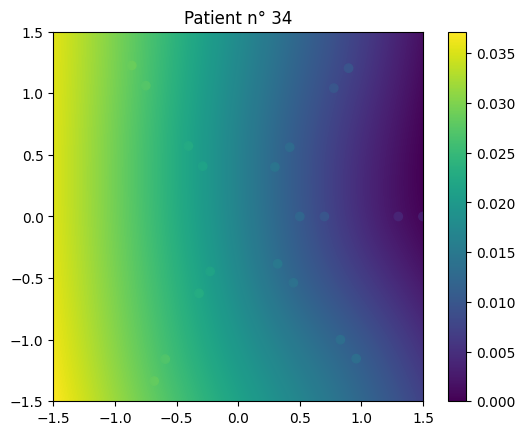

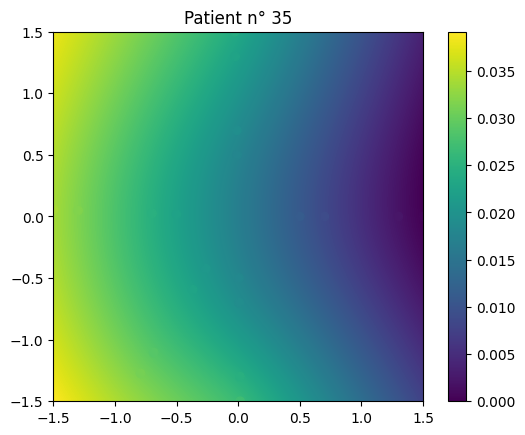

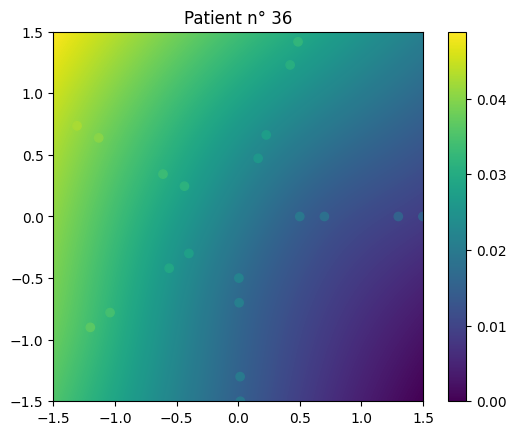

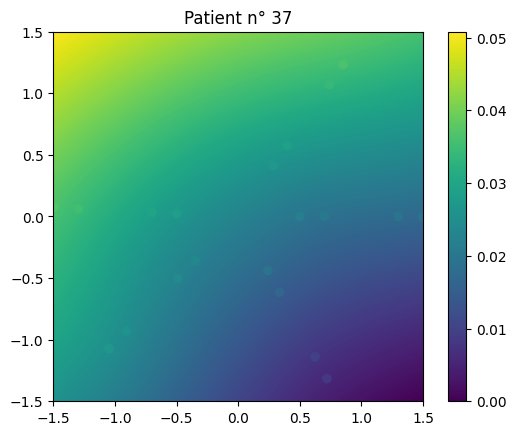

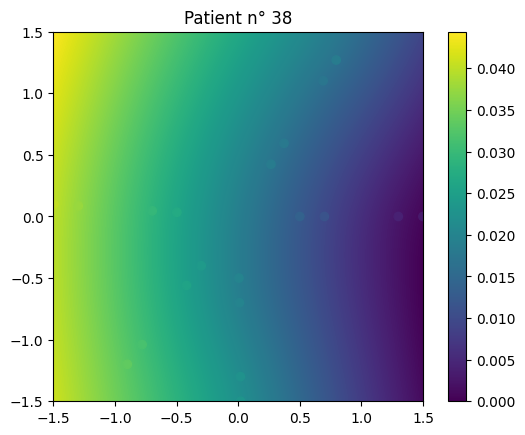

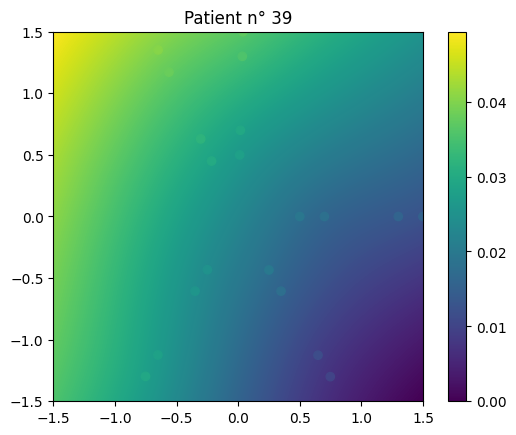

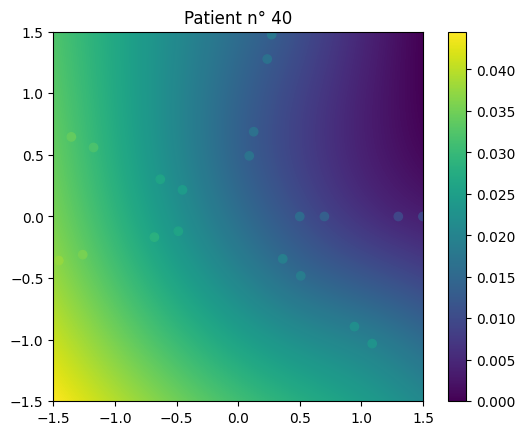

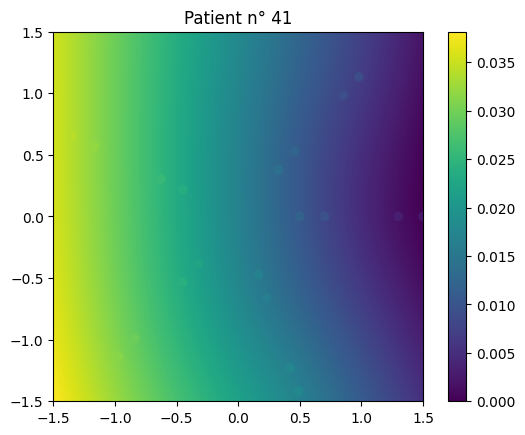

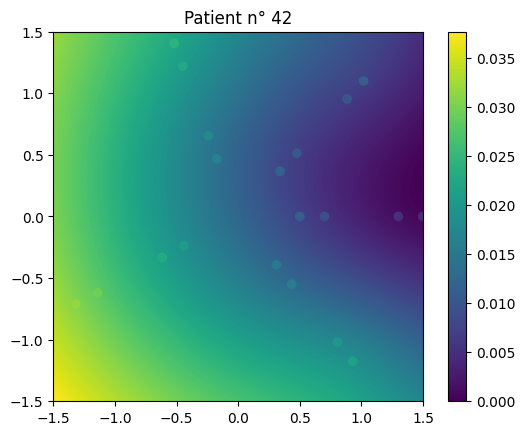

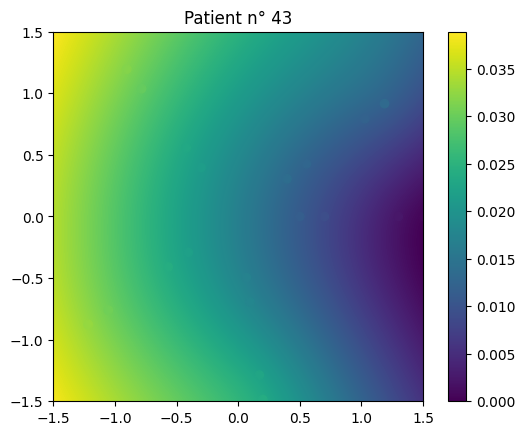

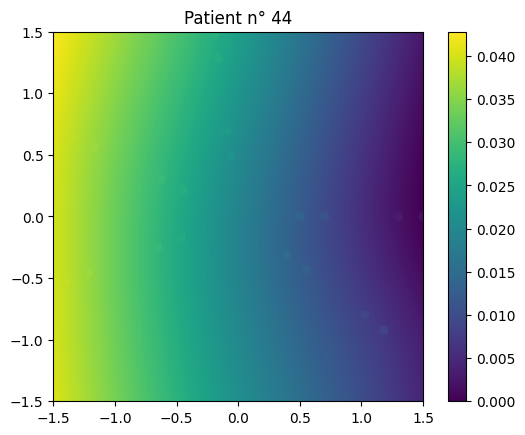

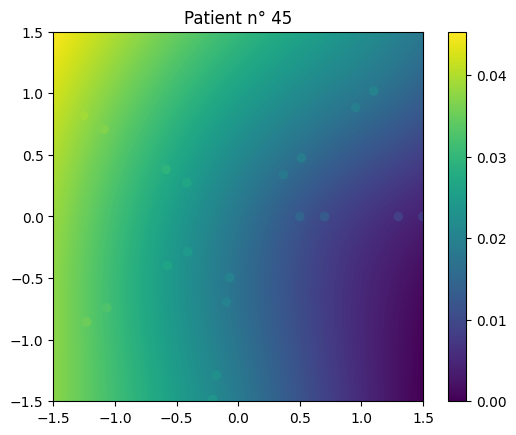

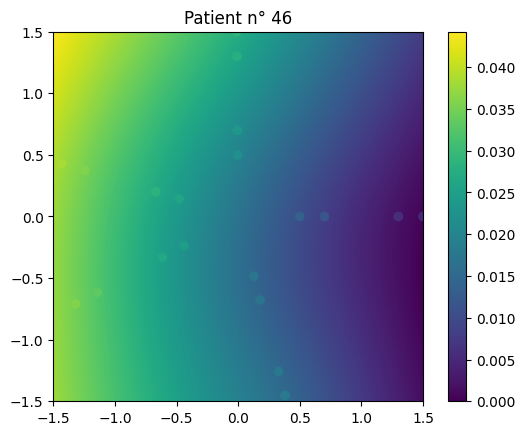

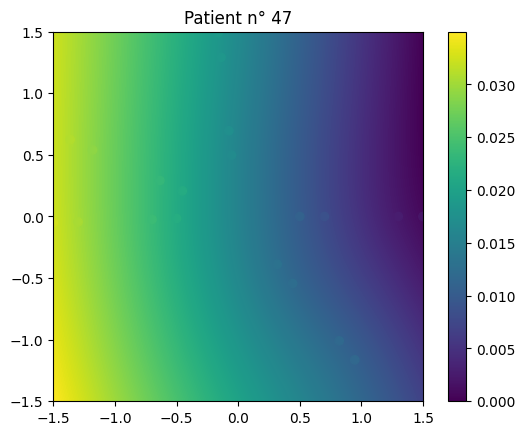

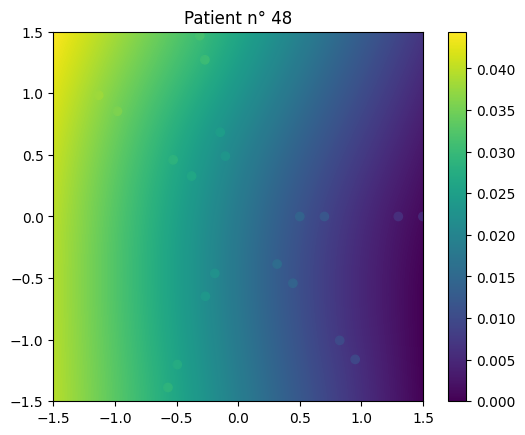

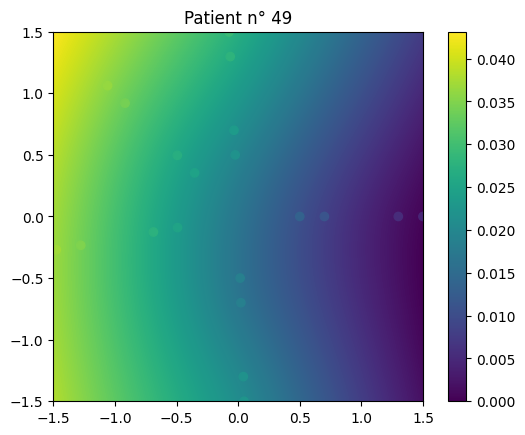

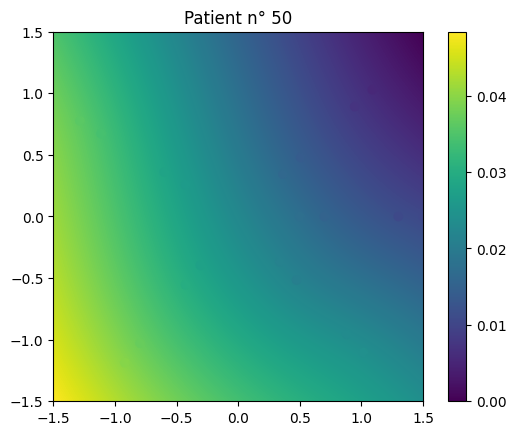

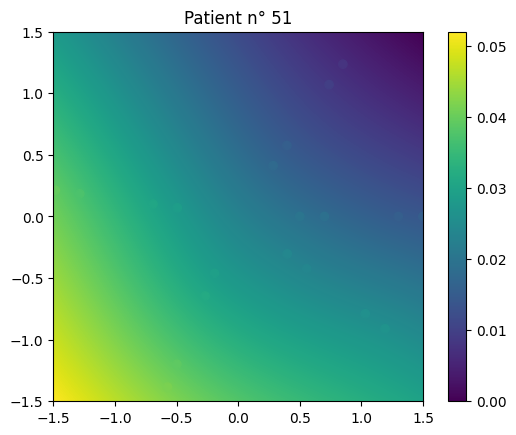

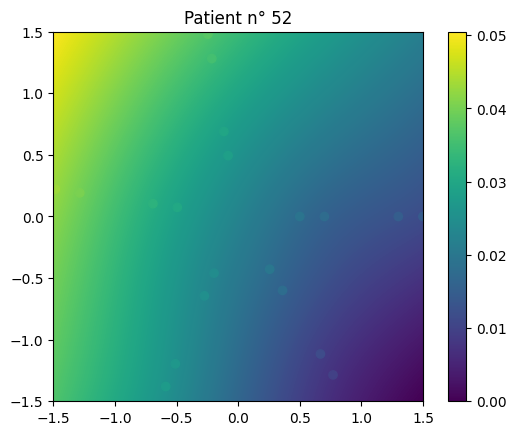

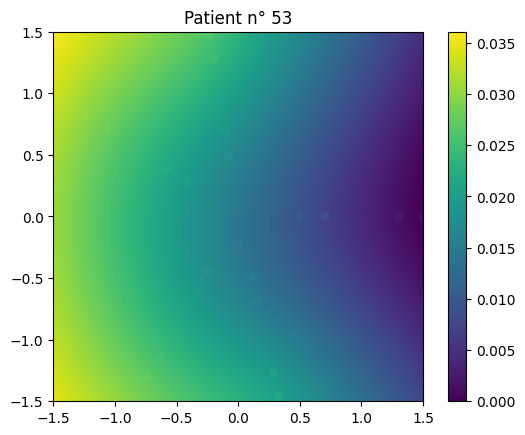

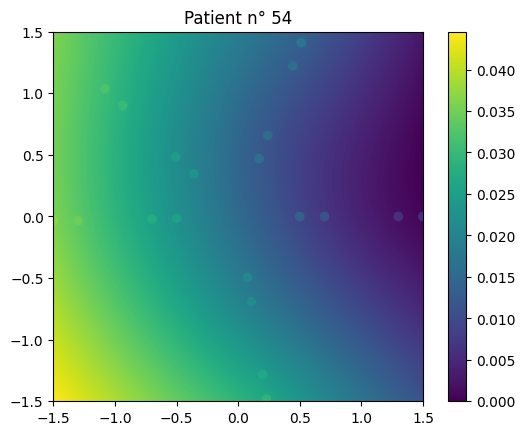

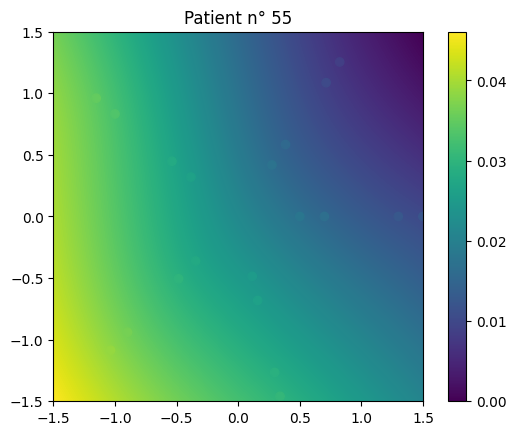

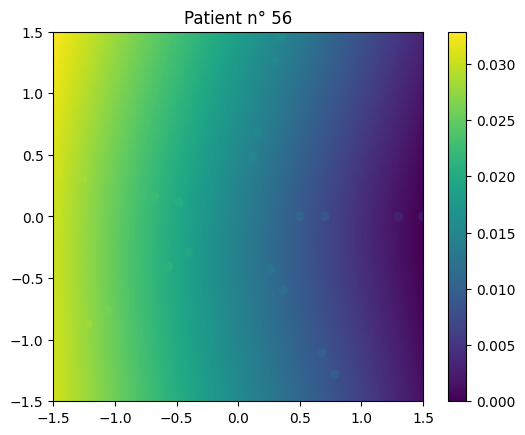

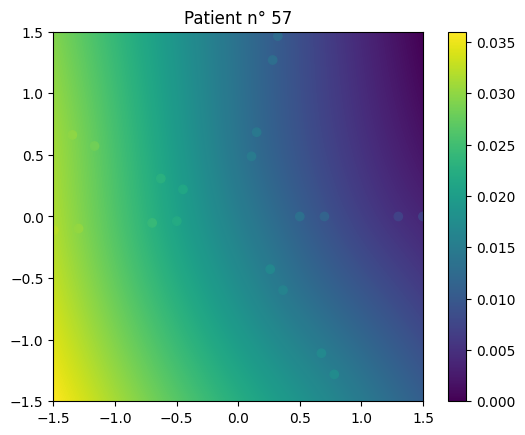

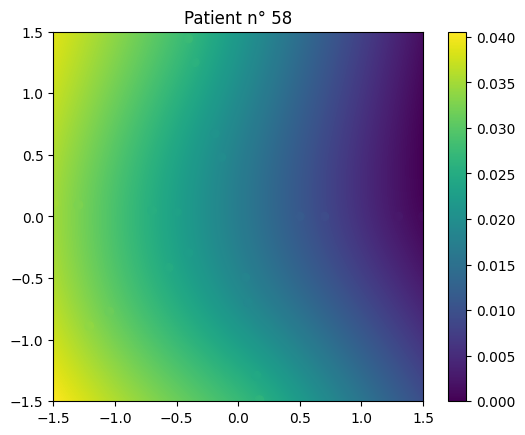

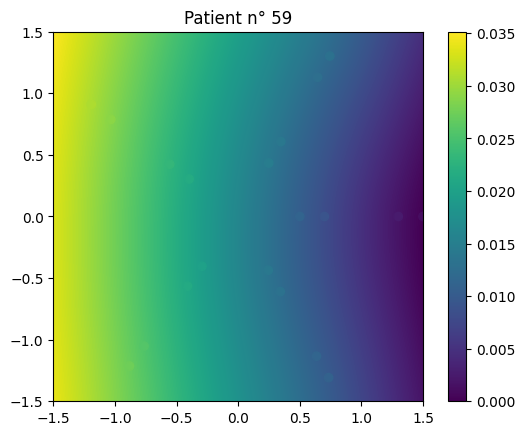

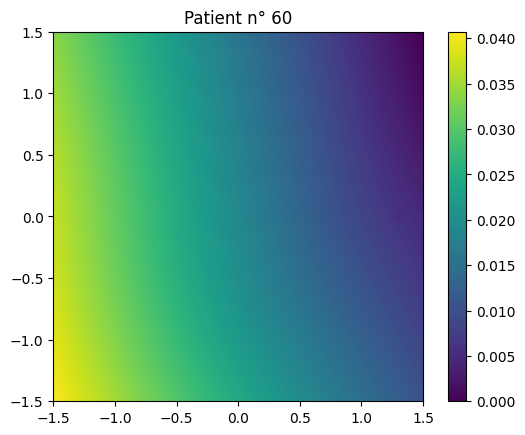

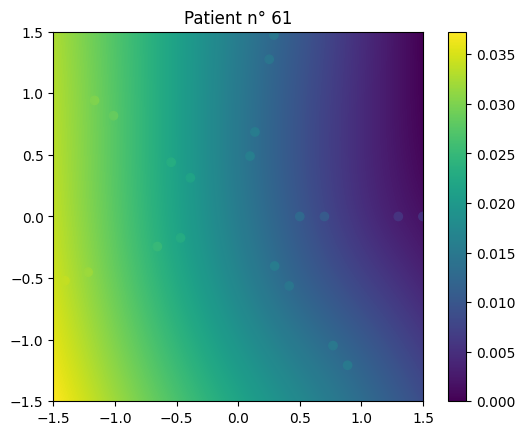

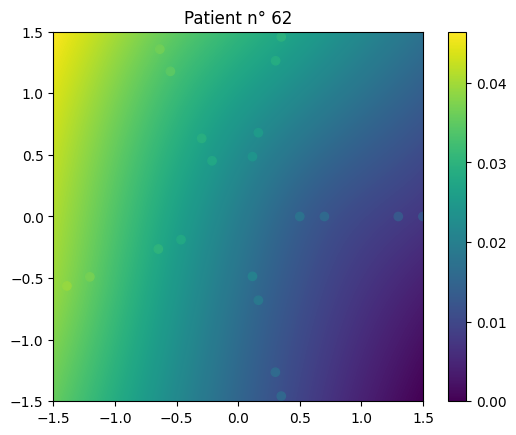

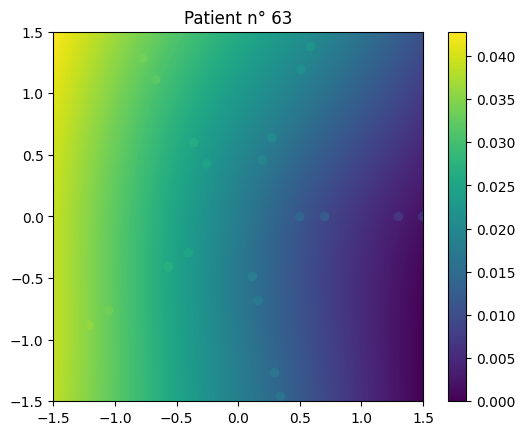

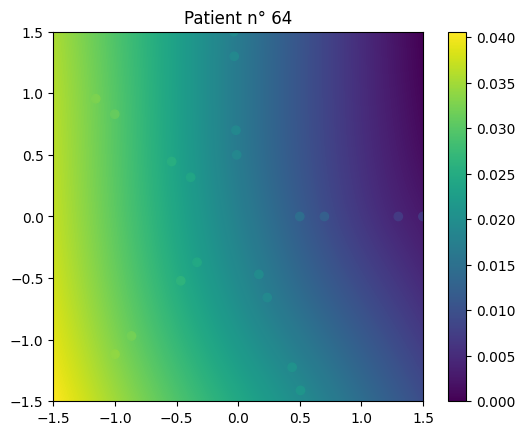

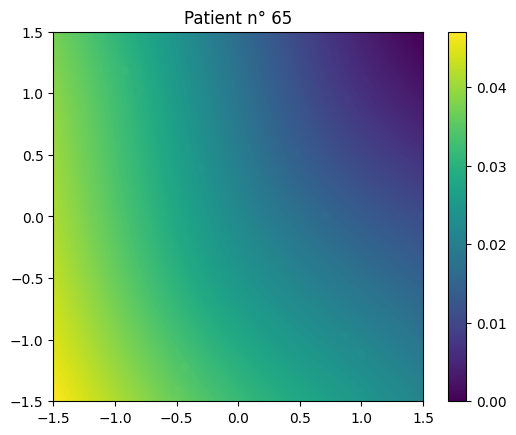

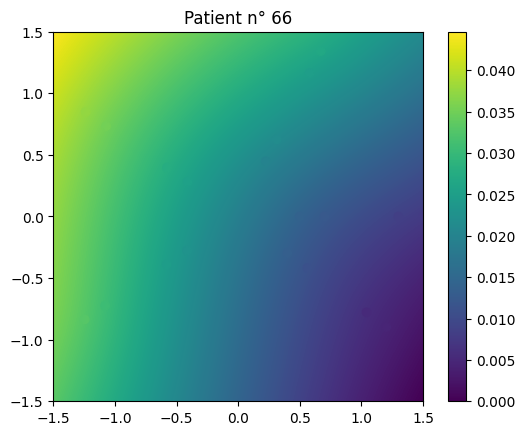

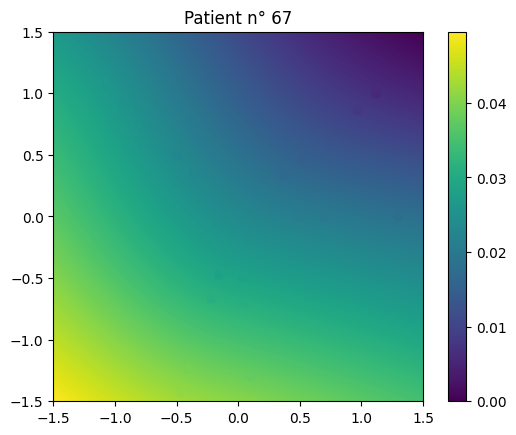

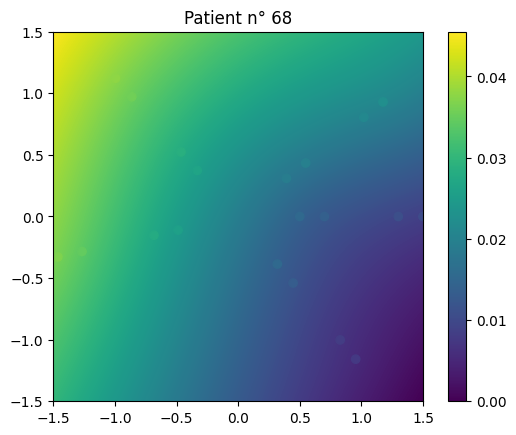

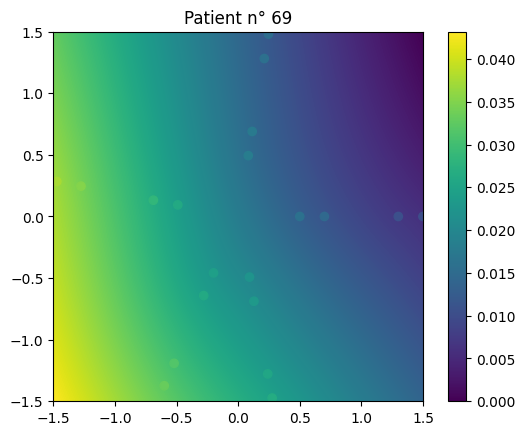

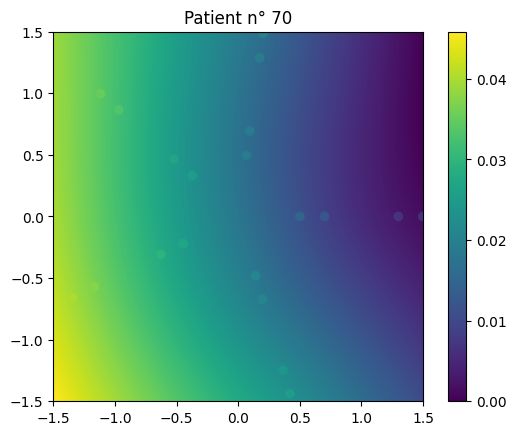

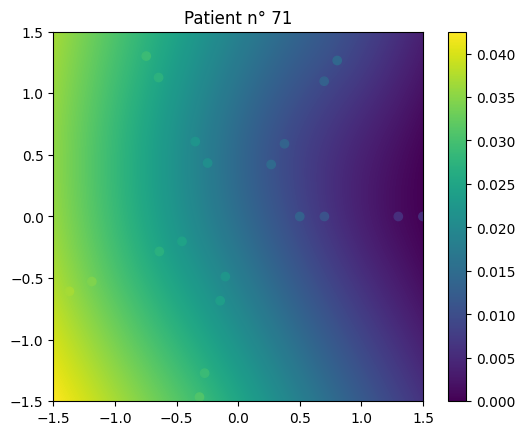

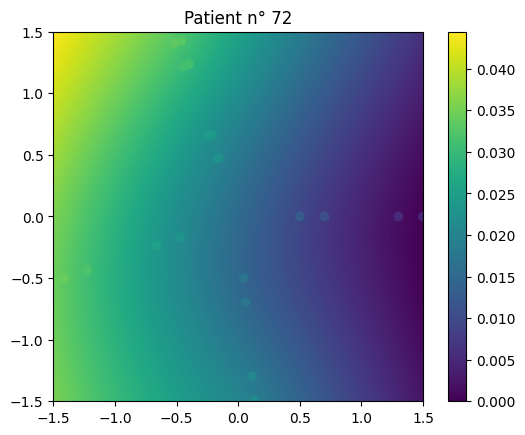

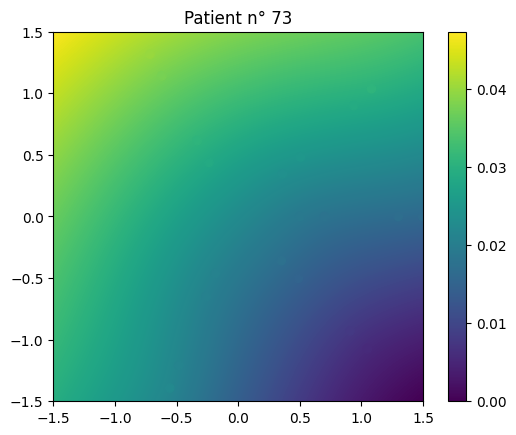

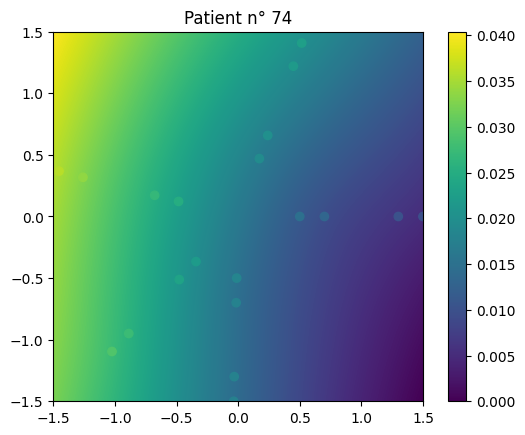

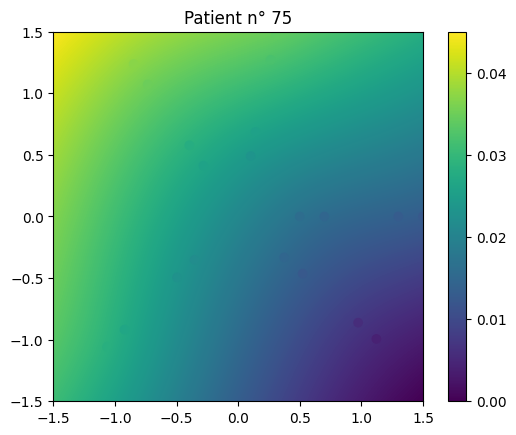

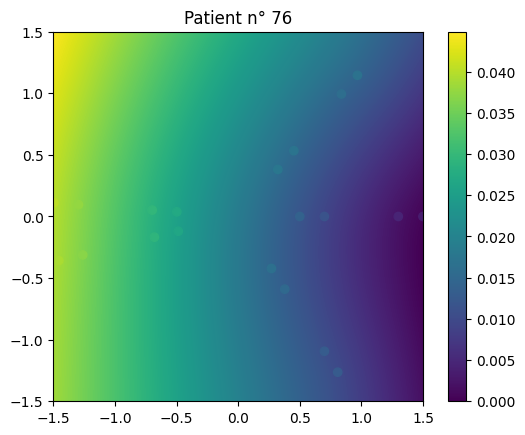

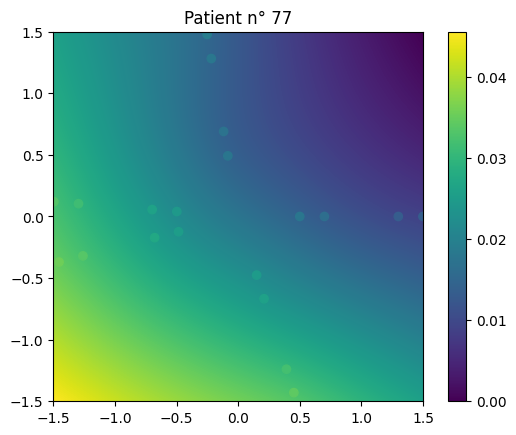

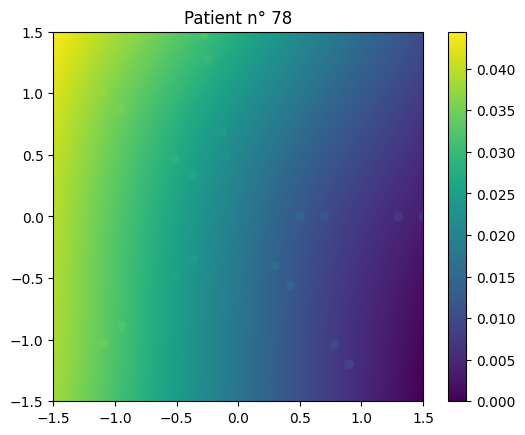

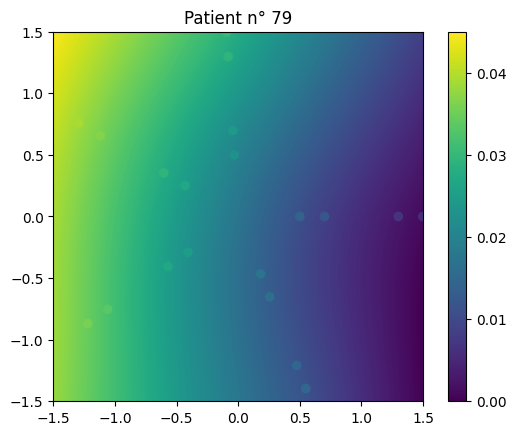

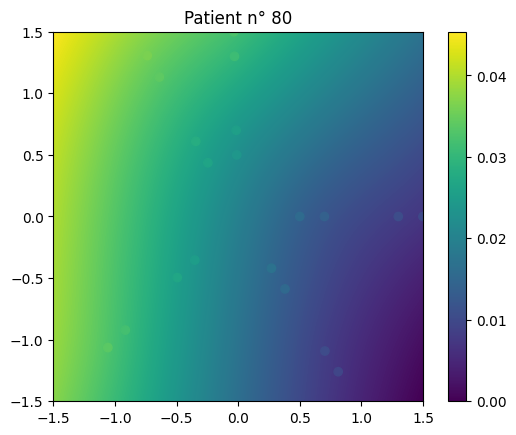

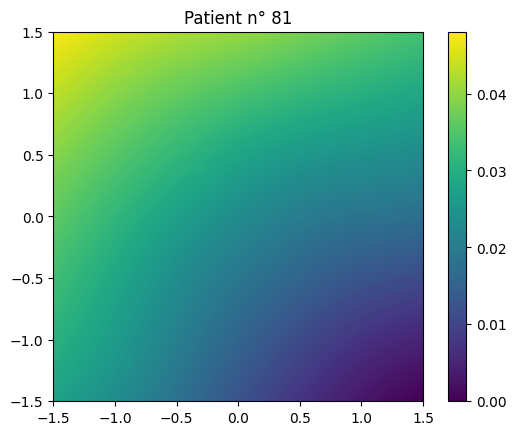

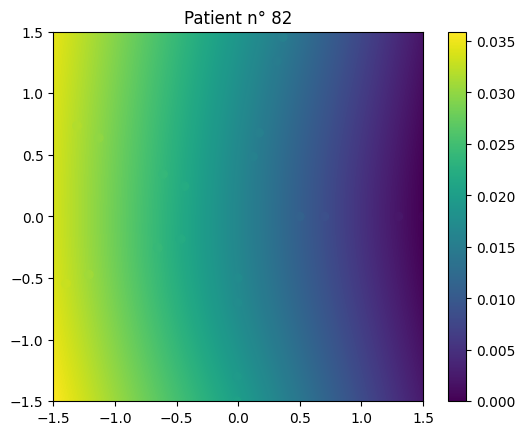

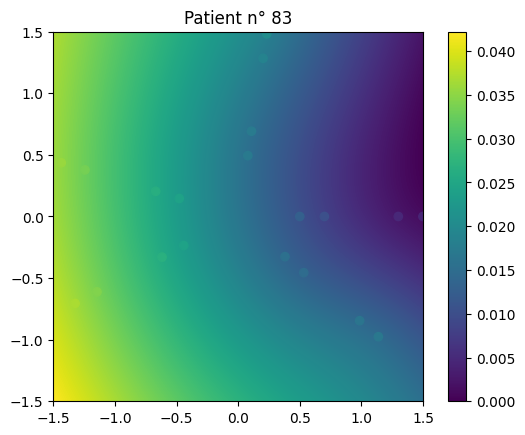

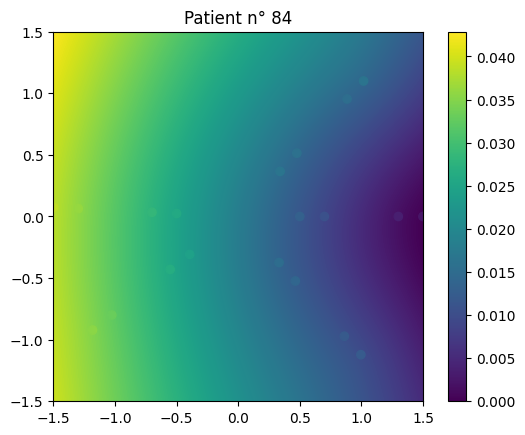

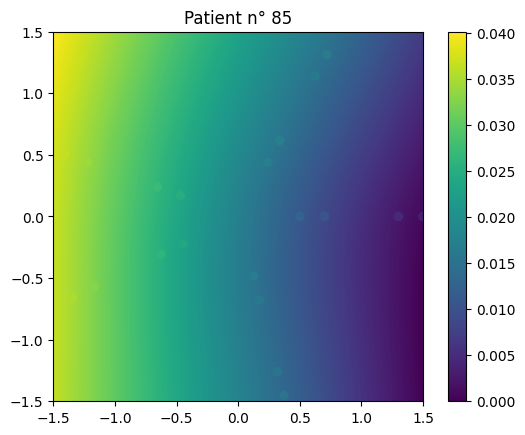

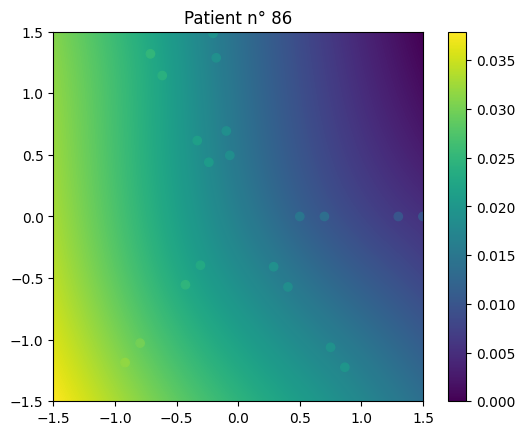

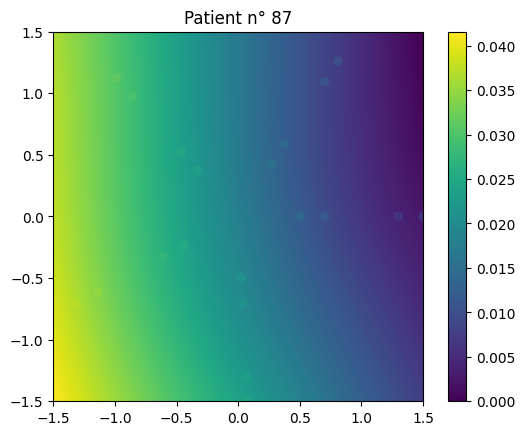

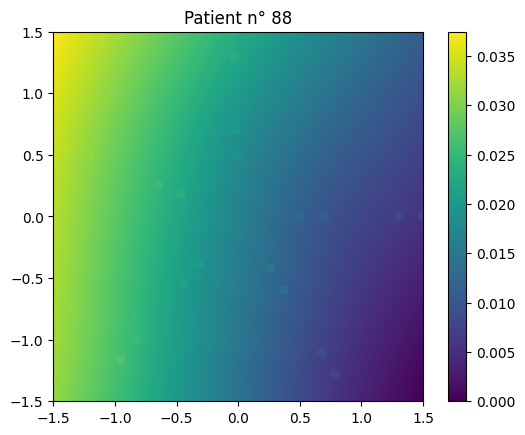

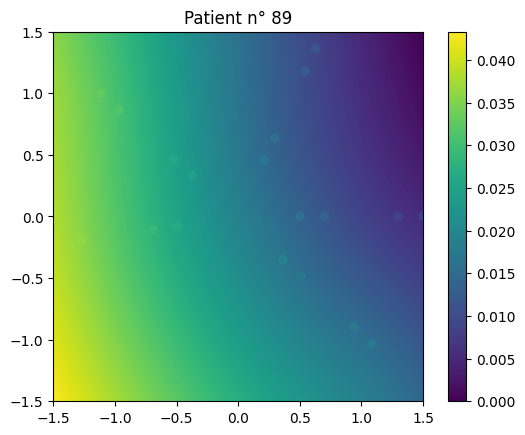

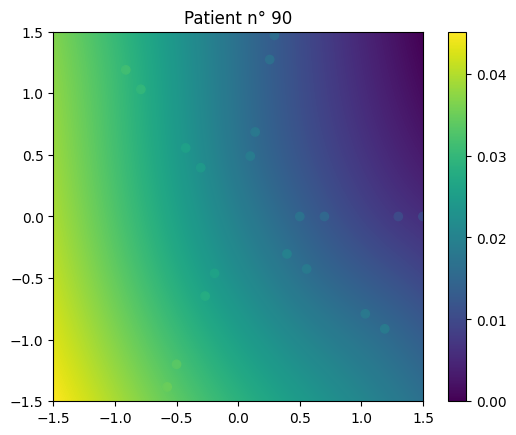

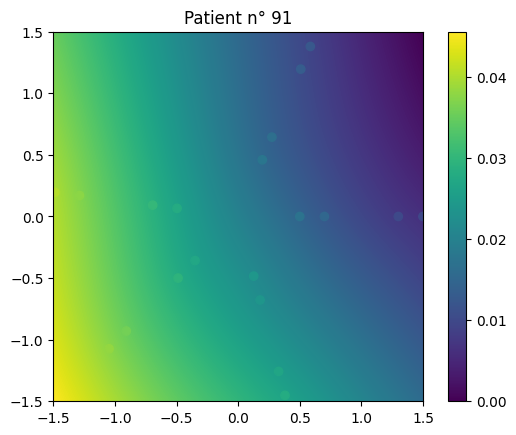

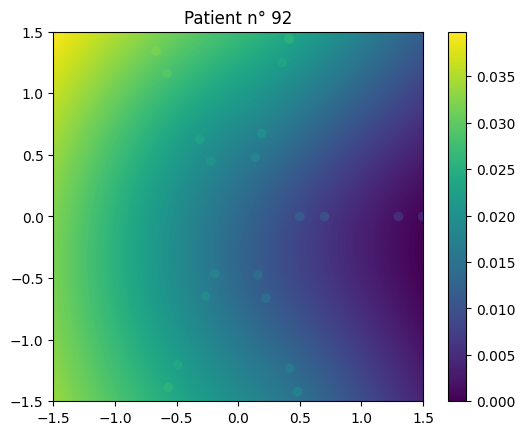

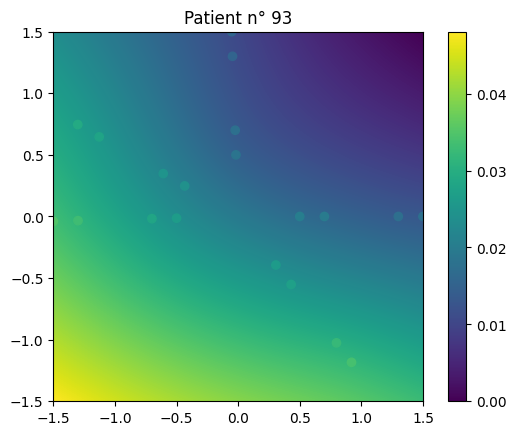

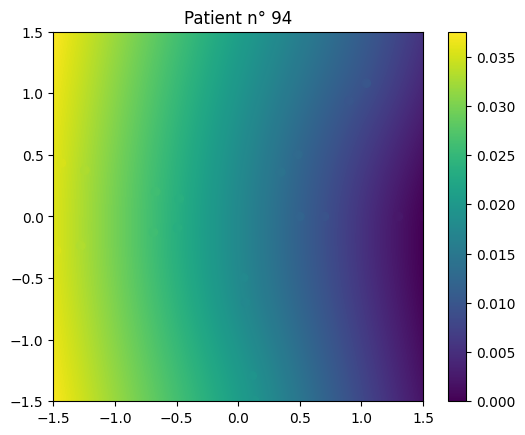

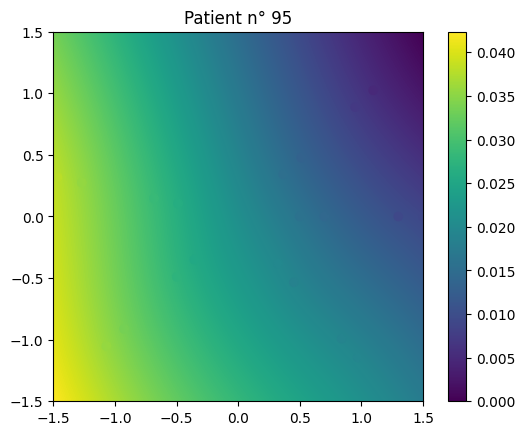

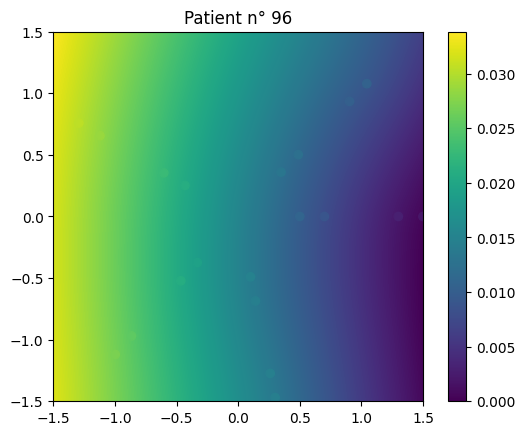

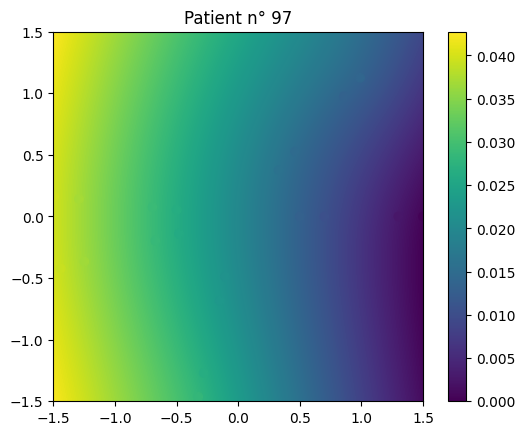

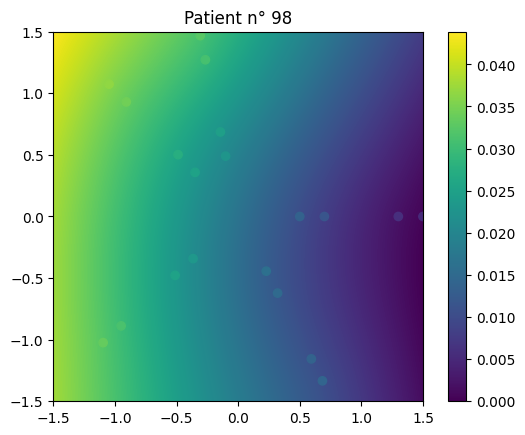

In [66]:
for i in range(99):
  x_meas = CP1data[i][0]
  y_meas = CP1data[i][1]
  t_meas = CP1data[i][2]

  time_pred,vel_pred = checkpoint1_solution(x_meas, y_meas, t_meas, X, Y, 0.2)

  num_rows = time_pred.shape[0] #need to swap the rows of the matrix of times if we want to use imshow matching the values of the time with the right (X,Y)
  for j in range(num_rows // 2):
    time_pred[j], time_pred[num_rows - 1 - j] = time_pred[num_rows - 1 - j], time_pred[j].copy()

  plt.imshow(time_pred, extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)])
  plt.scatter( x_meas,  y_meas, c=t_meas, vmin= 0, vmax=np.max(time_pred))
  plt.gca().set_aspect(1)
  plt.title(f'Patient n° {i}')
  plt.colorbar()
  plt.show()